In [1]:
from ngsolve import *
#from ngsolve.webgui import Draw
from netgen.occ import *
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

def matvec_b(v):
    tmp1.data = v
    tmp2.data = b * tmp1
    return tmp2.FV().NumPy()


def matvec_c(v):
    tmp3.data = v
    tmp4.data = c.mat * tmp3
    return tmp4.FV().NumPy()

In [2]:
def H1_Primal_Dual_L2IP(mesh):

    pv = mesh.vertices
    nv = len(pv)
    #Setup

    #Barycentric Refinement
    mesh.ngmesh.SplitPowellSabin()

    #for fine to coarse mapping
    fes_primal = Compress(H1(mesh, order=1))

    H1_u = fes_primal.TrialFunction()
    H1_v = fes_primal.TestFunction()

    #for mapping to dual
    fes_dual = Compress(L2(mesh, order=0))

    L2_u = fes_dual.TrialFunction()
    L2_v = fes_dual.TestFunction()

    #L2 inner product of H1 and L2 basis function on barycentrically refined mesh
    H1_L2_L2IP = BilinearForm(trialspace=fes_primal, testspace=fes_dual) #fes_dual)
    H1_L2_L2IP += H1_u * L2_v * dx

    H1_L2_L2IP.Assemble()
    #print(H1_L2_L2IP.mat.shape)

    # mapping to dual 
    data_length = 0

    for v in pv:
        # print(v, v.point)
        # print(v.faces)
        data_length += len(v.faces)

    #print(data_length)

    data1 = np.zeros(data_length)
    row_ind1 = np.zeros(data_length, dtype=int)
    col_ind1 = np.zeros(data_length, dtype=int)

    j = 0

    for v in pv:
        #print(v.nr)
        coeff =  1#/len(v.elements)
        #v_dofnr = fes_primal.GetDofNrs(v)[0]
        #print(v_dofnr)
        for el in v.elements:
            #print(f)
            el_dofNr = fes_dual.GetDofNrs(el)
            #print(dofNr)
            row_ind1[j] = el_dofNr[0]
            col_ind1[j] = v.nr
            data1[j] = coeff
            j += 1
    ne = mesh.ne
    dual_map = la.SparseMatrixdouble.CreateFromCOO(row_ind1,col_ind1,data1,ne,nv)
    #print(dual_map.shape)

    
    # mapping to coarse primal

    data_length = 0

    for par in pv:
        for el in par.elements:
            data_length += 3

    data = np.zeros(data_length)
    row_ind = np.zeros(data_length, dtype=int)
    col_ind = np.zeros(data_length, dtype=int)

    j = 0

    for par in pv:
        #print(v)
        par_dofnr = fes_primal.GetDofNrs(par)[0]
        par_nf = len(par.faces)
        for el in par.elements:
            ele = mesh.__getitem__(el)
            for v in ele.vertices:
                ver = mesh.__getitem__(v)
                child_dofnr = fes_primal.GetDofNrs(v)[0]
                #print(dofnr)
                row_ind[j] = par_dofnr
                col_ind[j] = child_dofnr
                #coarse vertices
                if par_dofnr == child_dofnr:
                    data[j] = 1/par_nf
                #barycenters
                elif len(ver.faces) == 6:
                    data[j] = 1/6
                #boundry elements
                elif len(ver.faces) == 2:
                    data[j] = 1/2
                else:
                    data[j] = 1/4
                j += 1

    primal_map = la.SparseMatrixdouble.CreateFromCOO(row_ind,col_ind,data, nv, mesh.nv)
    #print(primal_map.shape)

    #dual_L2IP = primal_map @ H1_L2_L2IP.mat @ dual_map.T
    dual_L2IP = dual_map.T @ H1_L2_L2IP.mat @ primal_map.T

    #dual_L2IP = primal_map @ H1_L2_L2IP.mat @ primal_map.T

    #dual_L2IP = dual_map.T @ H1_L2_L2IP.mat @ dual_map

    #print(dual_map.nze)    
    #print(H1_L2_L2IP.mat.ToDense())
    #print(primal_map.nze)



    return dual_L2IP


# netgen_mesh = unit_square.GenerateMesh(maxh=0.25)

# mesh = Mesh(netgen_mesh)

# matrix = H1_Primal_Dual_L2IP(mesh)

# print(matrix.shape)

In [3]:
#l is number of meshwidths, the n-th meshwidth is 1/(2^(n-1))
l = 6
meshwidths = np.ones(l) 
for h in range(l-1):
    meshwidths[h+1] = meshwidths[h]/2

print(meshwidths)
#order for which the elements corresponds to the whitney forms
low_order = 1

#amount of orders for the high-Order space
high_orders = 1 
#array storing the minimal Eigenvalue for given orders and meshwidth
minEV = np.zeros((high_orders,l))

#TODO remove low oder iteration

lowest_high_Order = low_order + 1
    #largest high order to test
highest_high_order = lowest_high_Order + high_orders

for i in range(lowest_high_Order, highest_high_order):
    print("polynomal order of low order space:", low_order, ", polynomal order of high order space:", i)
    for k in range(l):
        mw = meshwidths[k]
        print("h=",mw)
        #Draw(mesh)

        netgen_mesh = unit_square.GenerateMesh(maxh=mw, segmentsperedge=k+1.2, grading=0.1)
        mesh=Mesh(netgen_mesh)

        netgen_dual = netgen_mesh.Copy()
        dual_mesh=Mesh(netgen_dual)

        #actual meshwidth
        elvol = Integrate(CoefficientFunction(1),mesh,element_wise=True)
        mesh_h = [(2*vol)**(1/2) for vol in elvol]
        print("actual meshwidth range",min(mesh_h),max(mesh_h), "\n")

        #set function space, for l=0 its normal lagrangian finite elements
        #need to compress to remove DOFs of unrefined mesh after refinement
        H_h = Compress(H1(mesh, order = low_order, complex=False)) # main function space
        w_h = GridFunction(H_h) #define vector for matvec wrapper
        H_H = Compress(H1(mesh, order = i, complex=False)) # high order Function space for Riesz representative  

        print("# DoFs of low order space:", H_h.ndof, ", # DoFs of high order space:", H_H.ndof)

        #low order
        u_h = H_h.TrialFunction() # define the trial function
        v_h = H_h.TestFunction() # define the test function
        #High order
        u_H = H_H.TrialFunction() # define the trial function
        v_H= H_H.TestFunction() # define the test function

        a = BilinearForm(H_H, symmetric=True, symmetric_storage=False) # define the H1 inner product on the high order space
        a += grad(u_H) * grad(v_H) * dx
        a += u_H*v_H * dx 
        a.Assemble()

        #mass matrix with mixed basis functions
        a_mixed = BilinearForm(trialspace=H_h, testspace=H_H)
        a_mixed += u_h*v_H*dx
        a_mixed.Assemble()

        m = BilinearForm(H_h, symmetric=True, symmetric_storage=False) #define m with the L2 inner product on the low order space
        m += u_h*v_h * dx 

        #using m to calculate the inverse of the dual matrix
        pre = Preconditioner(m, "direct")
        m.Assemble()

        m_dual = H1_Primal_Dual_L2IP(dual_mesh)

        #compute inverses 
        a_inv = a.mat.Inverse()#inverse="sparsecholesky")
        #m_inv = m.mat.Inverse(inverse="sparsecholesky")

        #create Matrices for GEV problem

        #c is the low order galerkin matrix
        c = BilinearForm(H_h, symmetric=True, symmetric_storage=False)
        c += grad(u_h) * grad(v_h) * dx
        c += u_h*v_h * dx 

        c.Assemble()

        #with 100000 iterations Inverse seems fine (inv_m * m ~ I)
        m_dual_inv = CGSolver(m_dual, pre.mat, maxsteps=1000)

        # matrix = m_dual @ m_dual_inv

        # print(matrix.ToDense())

        m_dual_invT = CGSolver(m_dual.T, pre.mat, maxsteps=1000)

        # matrixT = m_dual.T @ m_dual_invT

        # print(matrixT.ToDense())

        # continue

        #matrix = m_dual.T @ m_dual_invT

        #print(matrix.ToDense())
        #break

        # b is the Matrix that lets us compute the norm of the Riesz representative
        # m==m.t, m_inv == m_inv.T
        b = c.mat.T @ m_dual_invT @ a_mixed.mat.T @ a_inv @ a_mixed.mat @ m_dual_inv @ c.mat

        tmp1 = w_h.vec.CreateVector()
        tmp2 = w_h.vec.CreateVector()

        tmp3 = w_h.vec.CreateVector()
        tmp4 = w_h.vec.CreateVector()

        B = sp.sparse.linalg.LinearOperator((b.height,b.width), matvec_b)
        C = sp.sparse.linalg.LinearOperator((c.mat.height,c.mat.width), matvec_c)            

        #The matrices Involved are Symmetric, so the symmetric solver is used
        #look for largest Eigenvalue of Bx = λCx, since ARPACK is more efficient for large EV's
        lam = sp.sparse.linalg.eigsh(B, k=1, M=C, which='LM', return_eigenvectors=False)
        print(lam)
        #if FEM space is complex need to take absolut value (the EV's have no imaginary part, but are still datatype complex)        
        #lam = np.abs(lam)
        #1/λ is the smallest EV of Cx = λBx
        minEV[i-lowest_high_Order,k] = 1/lam[0]

        print("\n")

print(minEV)

[1.      0.5     0.25    0.125   0.0625  0.03125]
polynomal order of low order space: 1 , polynomal order of high order space: 2
h= 1.0
actual meshwidth range 0.999999999999998 0.9999999999999981 

# DoFs of low order space: 4 , # DoFs of high order space: 9
[1.]


h= 0.5
actual meshwidth range 0.4326375199553749 0.5600419897084727 

# DoFs of low order space: 9 , # DoFs of high order space: 25
[1.11112311]


h= 0.25
actual meshwidth range 0.1854300870971452 0.3067363989577544 

# DoFs of low order space: 26 , # DoFs of high order space: 85
[1.06856222]


h= 0.125
actual meshwidth range 0.0851139651875047 0.1516226278076589 

# DoFs of low order space: 89 , # DoFs of high order space: 321
[1.05678614]


h= 0.0625
actual meshwidth range 0.04292982337891495 0.07505797015948051 

# DoFs of low order space: 338 , # DoFs of high order space: 1285
[1.05682507]


h= 0.03125
actual meshwidth range 0.021814871885731283 0.04138236403116654 

# DoFs of low order space: 1259 , # DoFs of high order

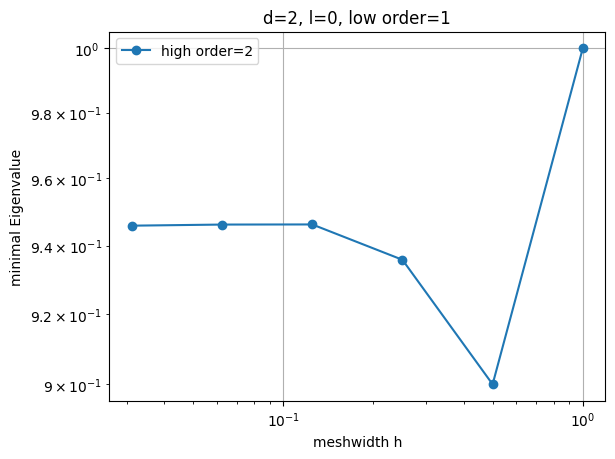

In [4]:
symbols = ['o-','h-.','*:','+-']

#minimal Ev

fig, ax = plt.subplots()
plt.grid(visible=True)
plt.title(label="d=2, l=0, low order=%i" %1)
#plt.loglog(meshwidths,np.ones(l) * 0.5,'--k', label="0.5")
plt.xlabel('meshwidth h')
plt.ylabel('minimal Eigenvalue')

lowest_high_Order = low_order + 1
highest_high_order = lowest_high_Order + high_orders
for i in range(lowest_high_Order,highest_high_order):
    plt.loglog(meshwidths,minEV[i-lowest_high_Order,:], symbols[i-lowest_high_Order], label="high order=%i"%i)

plt.legend()
plt.show()
